### UMAP can use for cluster too. But cluster need to discuss, as result cluster might not be soo real.

In [2]:
# use MNIST data.
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [3]:
# load mnist data, about 1-2 min is normal, longer will suspect network error.
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

c:\ProgramData\anaconda3\envs\umapzr\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


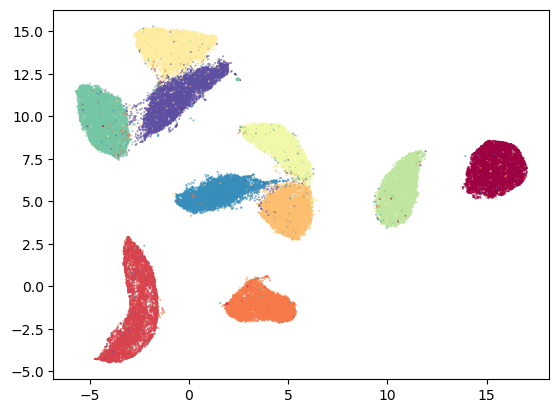

In [4]:
# show mnist data in normal method 
standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

### Traditional K-means cluster. One of the problem is the correct number of K.
Here we know there are 10 clusts(10 numbers)

c:\ProgramData\anaconda3\envs\umapzr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


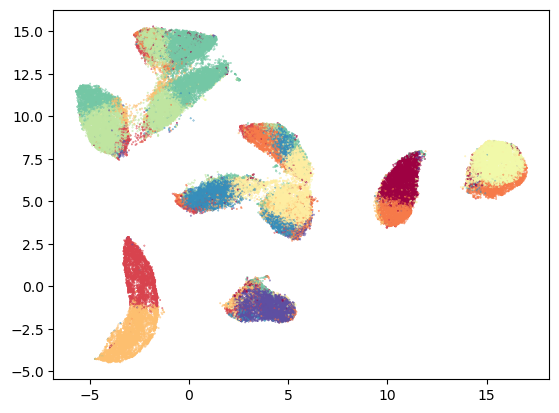

In [10]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(mnist.data) # out put with label 0-9
# let's see the result of cluster.
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [11]:
# rand index describe distribution similarity, and mutal info score show similarity too. Both 0-1, bigger for more similar.
(adjusted_rand_score(mnist.target, kmeans_labels),adjusted_mutual_info_score(mnist.target, kmeans_labels))

(0.36523930151098133, 0.4996170014369878)

That sucks! But it is the maximun ability of raw k-means. <br>
HDBScan can do better, it's considered as the most modern cluster method.<br>
HDBScan will refuse strange point cluser(noise), so performance can be better.

In [12]:
lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)# reduce data noise to front 50 pc
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist) # 10 cluser, at least 500 points each.

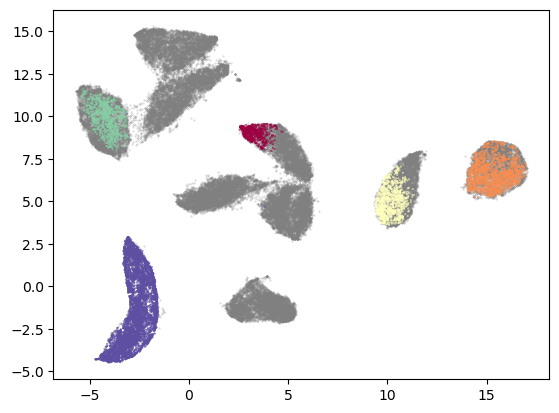

In [17]:
clustered = (hdbscan_labels >= 0)# unclustered data is -1, so in plot will be false.
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5) # plot all data in gray
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral') # annontate clustered data in color.

It's even sucker = = this method refuse to cluster most data to maintain presicion.

In [29]:
# HDBSCAN perform good on it clustered data, but most points they refuse to clust.
print(f'Raw data cluster similarity: {(adjusted_rand_score(mnist.target, hdbscan_labels),adjusted_mutual_info_score(mnist.target, hdbscan_labels))}')


clustered = (hdbscan_labels >= 0)
print(f'Only worked data cluster similarity: {(adjusted_rand_score(mnist.target[clustered], hdbscan_labels[clustered]),adjusted_mutual_info_score(mnist.target[clustered], hdbscan_labels[clustered]))}')

clused_num = np.sum(clustered) / mnist.data.shape[0]
print(f'Only {clused_num*100:.2f}% of all data clustered.')

Raw data cluster similarity: (0.05356217687645351, 0.305502412827051)
Only worked data cluster similarity: (0.9987404049390396, 0.9966121950557397)
Only 16.93% of all data clustered.


##### Here, we use UMAP to do cluster.<br>
For cluster task, bigger ***n_neighbors*** is necessary to avoid local noise.

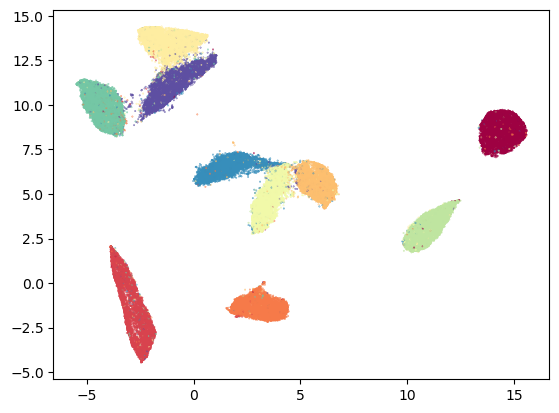

In [30]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(mnist.data) 
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=mnist.target, s=0.1, cmap='Spectral')
# you can also use fit() and umap.plot.points

Do above again with k-means, we will see the improve.

c:\ProgramData\anaconda3\envs\umapzr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


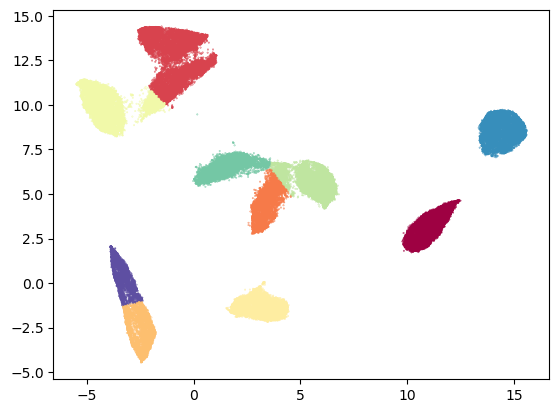

In [33]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(clusterable_embedding) # out put with label 0-9
# let's see the result of cluster.
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

And Use HDBSCAN again.

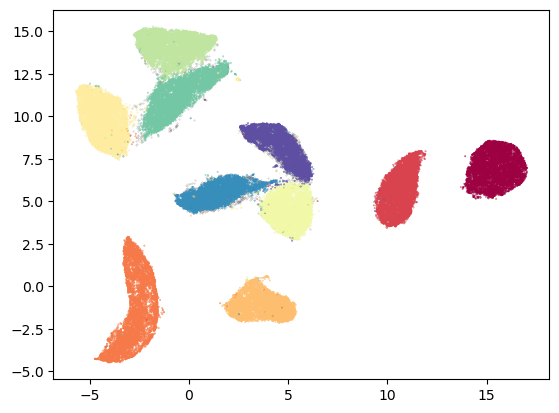

In [34]:
labels = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=500,).fit_predict(clusterable_embedding)
# still, plot only labeled data.
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [39]:
# HDBSCAN perform good on it clustered data, but most points they refuse to clust.



print(f'Raw data cluster similarity: {(adjusted_rand_score(mnist.target, labels),adjusted_mutual_info_score(mnist.target, labels))}')

clustered = (labels >= 0)
print(f'Worked data cluster similarity: {(adjusted_rand_score(mnist.target[clustered], labels[clustered]),adjusted_mutual_info_score(mnist.target[clustered], labels[clustered]))}')

clused_num = np.sum(clustered) / mnist.data.shape[0]
print(f' {clused_num*100:.2f}% of all data clustered.')

Raw data cluster similarity: (0.9203495984323325, 0.905871770576138)
Worked data cluster similarity: (0.9347552700648303, 0.9218309182007345)
 98.56% of all data clustered.
